# Feature Overview

This notebook provides a simple overview of the basic functionality of PySINDy. In addition to demonstrating the basic usage for fitting a SINDy model, we demonstrate several means of customizing the SINDy fitting procedure. These include different forms of input data, different optimization methods, different differentiation methods, and custom feature libraries.

An interactive version of this notebook is available on binder.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v1.7.3?filepath=examples/1_feature_overview.ipynb)

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from derivative import dxdt
from scipy.integrate import solve_ivp
from scipy.integrate import odeint

In [5]:
import warnings
from contextlib import contextmanager
from copy import copy
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.linalg import LinAlgWarning
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import Lasso

import pysindy as ps
from pysindy.utils import enzyme
from pysindy.utils import lorenz
from pysindy.utils import lorenz_control

if __name__ != "testing":
    t_end_train = 10
    t_end_test = 15
else:
    t_end_train = 0.04
    t_end_test = 0.04

data = (Path() / "../data").resolve()


@contextmanager
def ignore_specific_warnings():
    filters = copy(warnings.filters)
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    warnings.filterwarnings("ignore", category=LinAlgWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    yield
    warnings.filters = filters


if __name__ == "testing":
    import sys
    import os

    sys.stdout = open(os.devnull, "w")

In [6]:
# Seed the random number generators for reproducibility
np.random.seed(150)

### A note on solve_ivp vs odeint before we continue
The default solver for `solve_ivp` is a Runga-Kutta method (RK45) but this seems to work quite poorly on a number of these examples, likely because they are multi-scale and chaotic. Instead, the LSODA method seems to perform quite well (ironically this is the default for the older `odeint` method). This is a nice reminder that system identification is important to get the right model, but a good integrator is still needed at the end!

In [7]:
# Initialize integrator keywords for solve_ivp to replicate the odeint defaults
integrator_keywords = {}
integrator_keywords["rtol"] = 1e-12
integrator_keywords["method"] = "LSODA"
integrator_keywords["atol"] = 1e-12

## Basic usage
We will fit a SINDy model to the famous Lorenz system:
$$ \dot{x} = \sigma (y - x),$$
$$ \dot{y} = x(\rho - z) - y, $$
$$ \dot{z} = x y - \beta z. $$


### Train the model

In [8]:
# Generate measurement data
dt = 0.002

t_train = np.arange(0, t_end_train, dt)
x0_train = [-8, 8, 27]
t_train_span = (t_train[0], t_train[-1])
x_train = solve_ivp(
    lorenz, t_train_span, x0_train, t_eval=t_train, **integrator_keywords
).y.T

t_test = np.arange(0, 15, dt)
t_test_span = (t_test[0], t_test[-1])
x0_test = np.array([8, 7, 15])
x_test = solve_ivp(
    lorenz, t_test_span, x0_test, t_eval=t_test, **integrator_keywords
).y.T


In [9]:
t_end_train

10

In [10]:
x_train

array([[-8.        ,  8.        , 27.        ],
       [-7.68350838,  7.96625062, 26.73151854],
       [-7.37398458,  7.92929187, 26.46998075],
       ...,
       [ 7.93562059, 11.84129942, 19.64682377],
       [ 8.01403909, 11.9500649 , 19.7315487 ],
       [ 8.09305564, 12.05853147, 19.81943575]])

In [11]:
# Instantiate and fit the SINDy model
model = ps.SINDy()
model.fit(x_train, t=dt)
model.print()

(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
(x2)' = -2.666 x2 + 1.000 x0 x1


### Assess results on a test trajectory

# My test

In [12]:
feature_names= ['x','y','z']
opt=ps.STLSQ(threshold=1.0)#degree of sparsity  
model2 = ps.SINDy(feature_names=feature_names, optimizer=opt)
model2.fit(x_train, t=dt)
model2.print()

(x)' = -9.999 x + 9.999 y
(y)' = -2.793 x
(z)' = 0.000


C:\Users\fisay\AppData\Roaming\Python\Python39\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (1.0) and eliminated all coefficients
  warnings.warn(


In [13]:
from sklearn.metrics import mean_squared_error
def plot_pareto(coefs, opt, model, threshold_scan, x_test, t_test):
    dt = t_test[1] - t_test[0]
    mse = np.zeros(len(threshold_scan))
    mse_sim = np.zeros(len(threshold_scan))
    for i in range(len(threshold_scan)):
        opt.coef_ = coefs[i]
        mse[i] = model.score(x_test, t=dt, metric=mean_squared_error)
        x_test_sim = model.simulate(x_test[0, :], t_test, integrator="odeint")
        if np.any(x_test_sim > 1e4):
            x_test_sim = 1e4
        mse_sim[i] = np.sum((x_test - x_test_sim) ** 2)
    plt.figure()
    plt.semilogy(threshold_scan, mse, "bo")
    plt.semilogy(threshold_scan, mse, "b")
    plt.ylabel(r"$\dot{X}$ RMSE", fontsize=20)
    plt.xlabel(r"$\lambda$", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    plt.figure()
    plt.semilogy(threshold_scan, mse_sim, "bo")
    plt.semilogy(threshold_scan, mse_sim, "b")
    plt.ylabel(r"$\dot{X}$ RMSE", fontsize=20)
    plt.xlabel(r"$\lambda$", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)

In [14]:
def plot_org_sim(org, sim, legend):
    plt.figure(figsize=(12, 7))  # Adjusts the figure size for better visibility
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Define a list of colors for the plots

    # Iterate over each dimension in the data
    for i in range(org.shape[1]):
        plt.plot(org[:, i], linestyle='-', color=colors[i % len(colors)], label=f'{legend[i]} Data')
        plt.plot(sim[:, i], linestyle='--', color=colors[i % len(colors)], label=f'{legend[i]} Simulation')
    
    plt.ylabel('Number of Cases', fontsize=14, fontweight='bold')  # Adding label for y-axis with font settings
    plt.xlabel('Day (Since First Case)', fontsize=14, fontweight='bold')  # Adding label for x-axis with font settings
    plt.title('Comparison of Original Data and Simulation', fontsize=16, fontweight='bold')  # Adding a title
    plt.legend(fontsize=12, loc='best')  # Adjusting legend settings
    plt.grid(True)  # Adding a grid for better readability of the plot
    plt.tight_layout()  # Adjust layout to prevent clipping of ylabel

    plt.show()  # Display the plot


In [15]:
# Make plots of the data and its time derivative
def plot_data_and_derivative(x, dt, deriv):
    feature_name = ["C", "D", "R"]
    plt.figure(figsize=(20, 5))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.plot(x[:, i], label=feature_name[i])
        plt.grid(True)
        plt.xlabel("t", fontsize=24)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.legend(fontsize=24)
    x_dot = deriv(x, t=dt)
    plt.figure(figsize=(20, 5))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.plot(x_dot[:, i], label=r"$\dot{" + feature_name[i] + "}$")
        plt.grid(True)
        plt.xlabel("Days", fontsize=24)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.legend(fontsize=24)

In [16]:

# Make an errorbar coefficient plot from the results of ensembling
def plot_ensemble_results(
    model, mean_ensemble, std_ensemble, mean_library_ensemble, std_library_ensemble
):
    # Plot results
    xticknames = model.get_feature_names()
    for i in range(10):
        xticknames[i] = "$" + xticknames[i] + "$"
    plt.figure(figsize=(18, 4))
    colors = ["b", "r", "k"]
    plt.subplot(1, 2, 1)
    plt.xlabel("Candidate terms", fontsize=22)
    plt.ylabel("Coefficient values", fontsize=22)
    for i in range(3):
        plt.errorbar(
            range(10),
            mean_ensemble[i, :],
            yerr=std_ensemble[i, :],
            fmt="o",
            color=colors[i],
            label=r"Equation for $\dot{" + feature_names[i] + r"}$",
        )
    ax = plt.gca()
    plt.grid(True)
    ax.set_xticks(range(10))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    ax.set_xticklabels(xticknames, verticalalignment="top")
    plt.subplot(1, 2, 2)
    plt.xlabel("Candidate terms", fontsize=22)
    for i in range(3):
        plt.errorbar(
            range(10),
            mean_library_ensemble[i, :],
            yerr=std_library_ensemble[i, :],
            fmt="o",
            color=colors[i],
            label=r"Equation for $\dot{" + feature_names[i] + r"}$",
        )
    ax = plt.gca()
    plt.grid(True)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=16, loc="upper right")
    ax.set_xticks(range(10))
    ax.set_xticklabels(xticknames, verticalalignment="top")


In [17]:
# Make 3d plots comparing a test trajectory, 
# an associated model trajectory, and a second model trajectory.
def make_3d_plots(x_test, x_sim, constrained_x_sim, last_label):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection="3d")
    plt.plot(
        x_test[:, 0],
        x_test[:, 1],
        x_test[:, 2],
        "k",
        label="Validation Lorenz trajectory",
    )
    plt.plot(x_sim[:, 0], x_sim[:, 1], x_sim[:, 2], "r", 
             label="SR3, no constraints")
    plt.plot(
        constrained_x_sim[:, 0],
        constrained_x_sim[:, 1],
        constrained_x_sim[:, 2],
        "b",
        label=last_label,
    )
    ax.set_xlabel("x", fontsize=20)
    ax.set_ylabel("y", fontsize=20)
    ax.set_zlabel("z", fontsize=20)
    plt.legend(fontsize=16, framealpha=1.0)
    plt.show()

In [18]:
# For Trapping SINDy, use optimal m, and calculate if identified model is stable
def check_stability(r, Xi, sindy_opt):
    N = int((r ** 2 + 3 * r) / 2.0)
    opt_m = sindy_opt.m_history_[-1]
    PL_tensor_unsym = sindy_opt.PL_unsym_
    PL_tensor = sindy_opt.PL_
    PQ_tensor = sindy_opt.PQ_
    mPQ = np.tensordot(opt_m, PQ_tensor, axes=([0], [0]))
    P_tensor = PL_tensor - mPQ
    As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
    eigvals, eigvecs = np.linalg.eigh(As)
    print("optimal m: ", opt_m)
    print("As eigvals: ", np.sort(eigvals))
    print(
        "All As eigenvalues are < 0 and therefore system is globally stable? ",
        np.all(eigvals < 0),
    )
    max_eigval = np.sort(eigvals)[-1]
    min_eigval = np.sort(eigvals)[0]
    L = np.tensordot(PL_tensor_unsym, Xi, axes=([3, 2], [0, 1]))
    Q = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
    d = np.dot(L, opt_m) + np.dot(np.tensordot(Q, opt_m, axes=([2], [0])), opt_m)
    Rm = np.linalg.norm(d) / np.abs(max_eigval)
    print("Estimate of trapping region size, Rm = ", Rm)

In [19]:
def make_constraints(r):
    q = 0
    N = int((r ** 2 + 3 * r) / 2.0)
    p = r + r * (r - 1) + int(r * (r - 1) * (r - 2) / 6.0)
    constraint_zeros = np.zeros(p)
    constraint_matrix = np.zeros((p, r * N))

    # Set coefficients adorning terms like a_i^3 to zero
    for i in range(r):
        constraint_matrix[q, r * (N - r) + i * (r + 1)] = 1.0
        q = q + 1

    # Set coefficients adorning terms like a_ia_j^2 to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            constraint_matrix[q, r * (N - r + j) + i] = 1.0
            constraint_matrix[
                q, r * (r + j - 1) + j + r * int(i * (2 * r - i - 3) / 2.0)
            ] = 1.0
            q = q + 1
    for i in range(r):
        for j in range(0, i):
            constraint_matrix[q, r * (N - r + j) + i] = 1.0
            constraint_matrix[
                q, r * (r + i - 1) + j + r * int(j * (2 * r - j - 3) / 2.0)
            ] = 1.0
            q = q + 1

    # Set coefficients adorning terms like a_ia_ja_k to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            for k in range(j + 1, r):
                constraint_matrix[
                    q, r * (r + k - 1) + i + r * int(j * (2 * r - j - 3) / 2.0)
                ] = 1.0
                constraint_matrix[
                    q, r * (r + k - 1) + j + r * int(i * (2 * r - i - 3) / 2.0)
                ] = 1.0
                constraint_matrix[
                    q, r * (r + j - 1) + k + r * int(i * (2 * r - i - 3) / 2.0)
                ] = 1.0
                q = q + 1

    return constraint_zeros, constraint_matrix



In [20]:
def Plotting_covid(x,y,approximation=False,u_approximation=0):
    plt.figure(figsize=(12, 7))
    plt.plot(x, y, marker='.', color='blue')
    if approximation==True:
        plt.plot(x, u_approximation, marker='.', color='red')
    plt.title('Increase of Infection Over First 50 Days for Diamond Princess')
    plt.xlabel('Day (Since First Case)')
    plt.ylabel('Number of Confirmed Cases')
    #plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


In [21]:
def CalcAccuracy(Actual_Y, Predicted_y):
    
    actual_values=Actual_Y
    predicted_values=np.array(Predicted_y)
    error= abs(actual_values-predicted_values)
    mse=np.mean(np.square(error))
    rel_err=mse/np.mean(np.square(actual_values))
    accuracy=1-rel_err
    return(accuracy)

In [22]:
def plot_func(x):
    plt.figure(figsize=(12, 7))  # Adjust figure size for better visibility
    plt.plot(x['Day'], x['CONFIRMED'], marker='o', linestyle='-', color='blue', label='Confirmed Cases')
    plt.plot(x['Day'], x['DEATHS'], marker='x', linestyle='-', color='red', label='Deaths')
    plt.plot(x['Day'], x['RECOVERED'], marker='s', linestyle='-', color='green', label='Recovered')

    plt.title('Increase of Infection Over First Days', fontsize=16, fontweight='bold')  # Adding a title with font settings
    plt.xlabel('Day (Since First Case)', fontsize=14, fontweight='bold')  # Adding label for x-axis with font settings
    plt.ylabel('Number of Cases', fontsize=14, fontweight='bold')  # Adding label for y-axis with font settings

    plt.legend(fontsize=12, loc='best')  # Adjusting legend settings for better readability
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Adding a grid for better readability of the plot

    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()  # Display the plot

# My test end

In [23]:
# Initialize integrator keywords for solve_ivp to replicate the odeint defaults
integrator_keywords = {}
integrator_keywords["rtol"] = 1e-12
integrator_keywords["method"] = "LSODA"#"RK45"
integrator_keywords["atol"] = 1e-12

## covid data 

In [24]:
corona_data = pd.read_csv('corona_data.dat', sep="\t", engine='python')  # Assuming tab-separated data


In [25]:
# Load the file using pandas

# Filter the data for "Diamond Princess"
diamond_princess_data = corona_data[corona_data['LOCATION'] == 'Diamond Princess']

#create day column
diamond_princess_data['Day'] = range(1, len(diamond_princess_data) + 1)
# Filter the Diamond Princess data for the first 50 days
diamond_princess_first_50_days = diamond_princess_data[diamond_princess_data['Day'] >= 0]

U_comp=diamond_princess_first_50_days[['CONFIRMED', 'DEATHS', 'RECOVERED']].to_numpy()
U_comp=U_comp.reshape(diamond_princess_first_50_days.shape[0],3)
T=diamond_princess_first_50_days['Day'].to_numpy()
T=T.reshape(diamond_princess_first_50_days.shape[0],1).flatten()
u0_comp=np.array([5,0,0])


C:\Users\fisay\AppData\Local\Temp\ipykernel_10772\2084908070.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diamond_princess_data['Day'] = range(1, len(diamond_princess_data) + 1)


In [26]:
# Filter the data for "Norway Data"
norway_data = corona_data[corona_data['LOCATION'] == 'Norway']

#create day column
norway_data['Day'] = range(1, len(norway_data) + 1)
# Filter the Diamond Princess data for the first 50 days
norway_data_first_50_days = norway_data[norway_data['Day'] >= 0]

U_comp_test_N=norway_data_first_50_days[['CONFIRMED', 'DEATHS', 'RECOVERED']].to_numpy()
U_comp_test_N=U_comp_test_N.reshape(norway_data_first_50_days.shape[0],3)
T_test_N=norway_data_first_50_days['Day'].to_numpy()
T_test_N=T_test_N.reshape(norway_data_first_50_days.shape[0],1).flatten()
norway_data

C:\Users\fisay\AppData\Local\Temp\ipykernel_10772\986090461.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norway_data['Day'] = range(1, len(norway_data) + 1)


,LOCATION,TIME,ELAPSED_TIME_SINCE_OUTBREAK,CONFIRMED,DEATHS,RECOVERED,Day
30058,Norway,2020-02-26 23:59:00,0,1,0,0,1
30059,Norway,2020-02-27 23:59:00,1,1,0,0,2
30060,Norway,2020-02-28 23:59:00,2,6,0,0,3
30061,Norway,2020-02-29 23:59:00,3,15,0,0,4
30062,Norway,2020-03-01 23:59:00,4,19,0,0,5
...,...,...,...,...,...,...,...
30296,Norway,2020-10-21 23:59:00,238,16964,279,11863,239
30297,Norway,2020-10-22 23:59:00,239,17234,279,11863,240
30298,Norway,2020-10-23 23:59:00,240,17532,279,11863,241
30299,Norway,2020-10-24 23:59:00,241,17749,279,11863,242


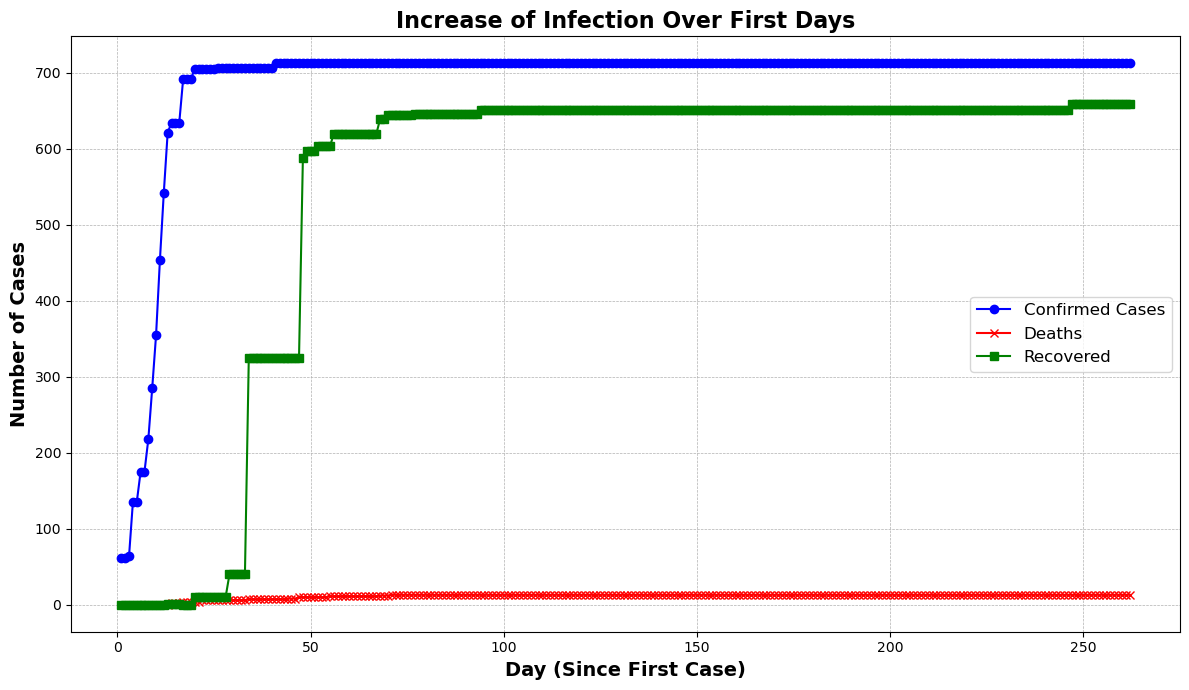

In [27]:
plot_func(diamond_princess_data)

In [28]:
a=[  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208,
       209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,
       222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
       235, 236, 237, 238, 239, 240, 241, 242, 243]

c:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
c:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
c:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
c:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODE

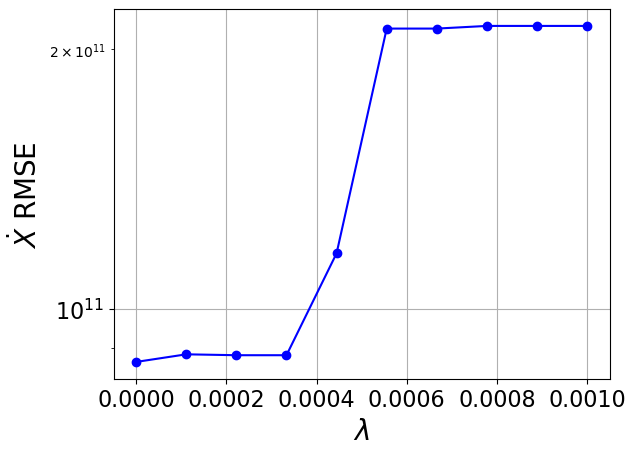

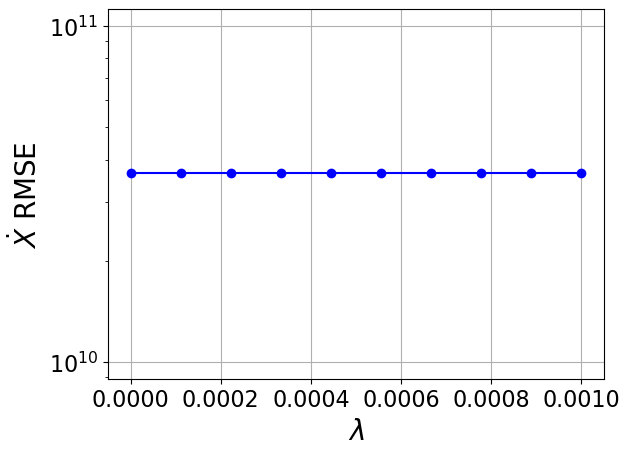

In [29]:
threshold_scan = np.linspace(0.0, 0.0010, 10)
coefs = []
for i, threshold in enumerate(threshold_scan):
    sparse_regression_optimizer = ps.STLSQ(threshold=threshold)
    library=ps.PolynomialLibrary(degree=2)
    model_test = ps.SINDy(feature_names=feature_names, feature_library=library, optimizer=sparse_regression_optimizer)
    model_test.fit(U_comp, t=0.5, quiet=True)
    coefs.append(model_test.coefficients())
    
plot_pareto(coefs, sparse_regression_optimizer, model_test, threshold_scan, U_comp_test_N, a)

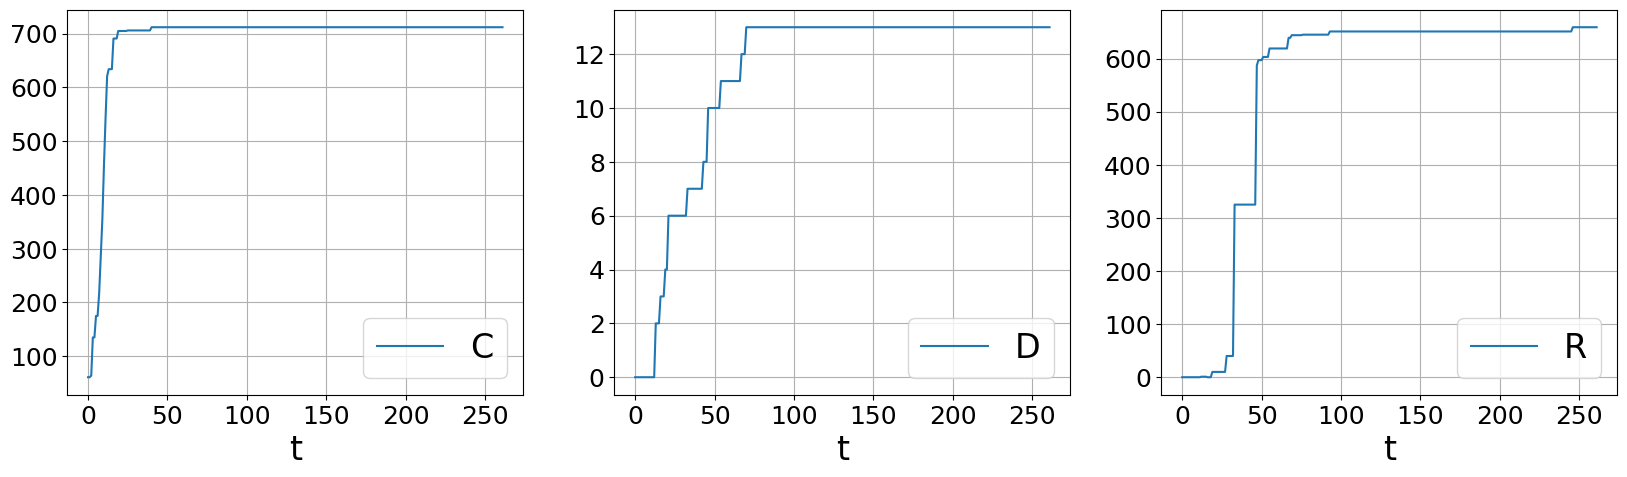

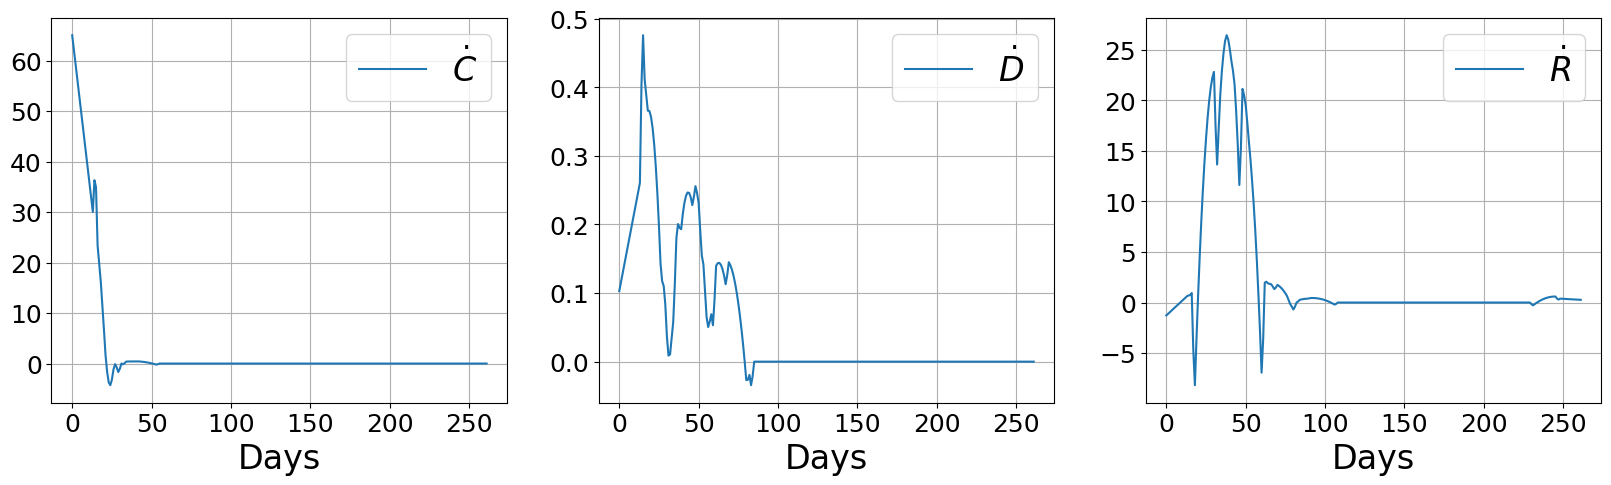

In [30]:
covid_dt=1
plot_data_and_derivative(U_comp,covid_dt, ps.SmoothedFiniteDifference(smoother_kws={'window_length': 30, 'polyorder': 2})._differentiate)

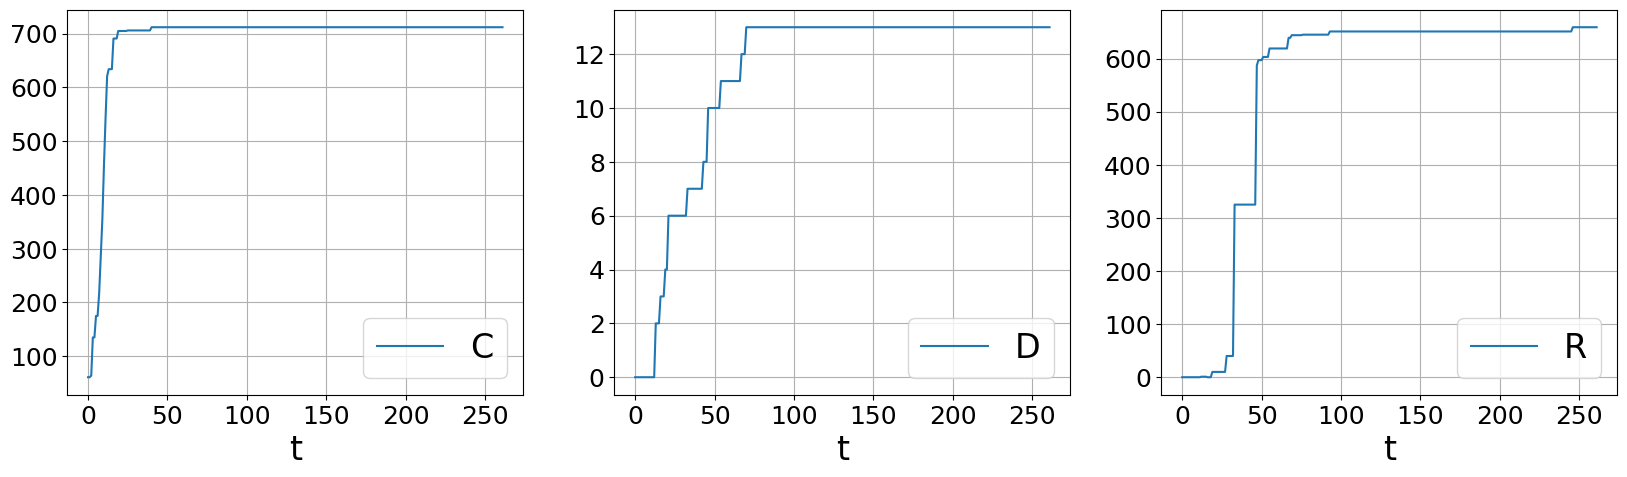

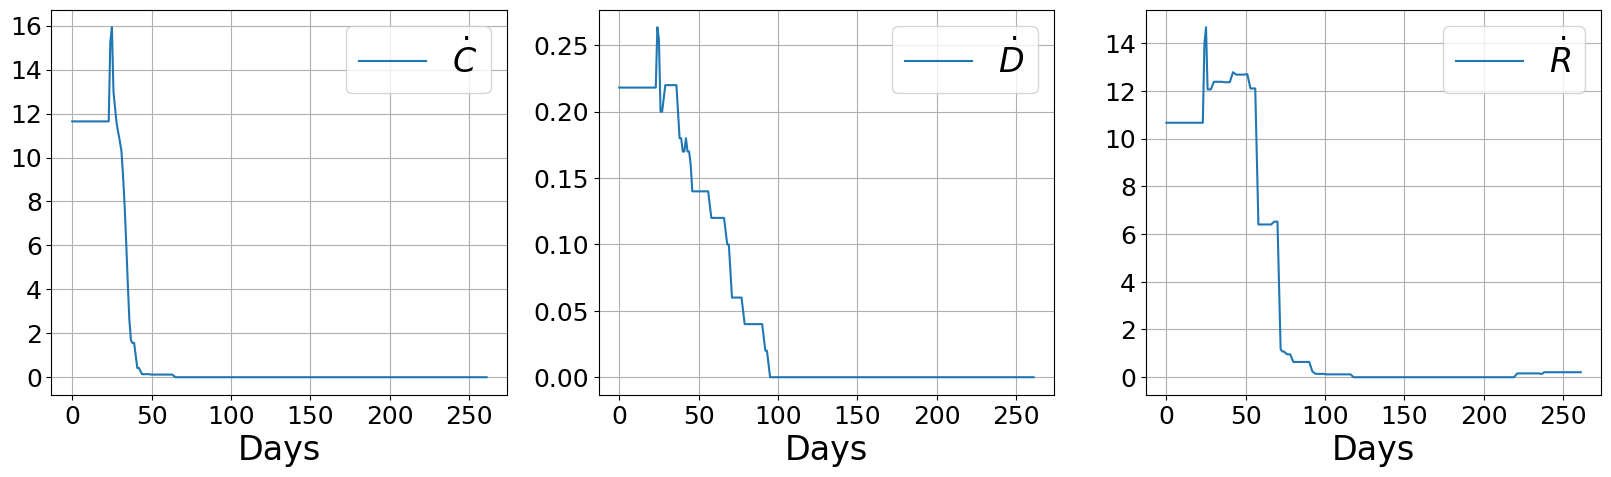

In [31]:
covid_dt=1
plot_data_and_derivative(U_comp,covid_dt, ps.SmoothedFiniteDifference(smoother_kws={'window_length': 50, 'polyorder': 1})._differentiate)

discuss terms and add time 

In [32]:
feature_names= ['C','D','R']
opt=ps.STLSQ(threshold=0.00001)#degree of sparsity  
library=ps.PolynomialLibrary(degree=1)
dm=ps.SmoothedFiniteDifference(smoother_kws={'window_length': 50, 'polyorder': 1})._differentiate
model_covid = ps.SINDy(feature_names=feature_names, feature_library=library,optimizer=opt,differentiation_method=dm)
model_covid.fit(U_comp, t=1)
model_covid.print()
u0_comp=np.array([10,0,0])
x_sim=model_covid.simulate(u0_comp,t=T)
print("Accuracy: " +str(CalcAccuracy(U_comp,x_sim)))

(C)' = 12.647 1 + -0.005 C + 0.490 D + -0.024 R
(D)' = 0.165 1 + -0.029 D
(R)' = 6.167 1 + 0.023 C + -2.235 D + 0.011 R
Accuracy: 0.9486158781383138


In [33]:
u0_comp=np.array([10,0,0])
x_sim=model_covid.simulate(u0_comp,t=T)

In [34]:
U_comp

array([[ 61,   0,   0],
       [ 61,   0,   0],
       [ 64,   0,   0],
       [135,   0,   0],
       [135,   0,   0],
       [175,   0,   0],
       [175,   0,   0],
       [218,   0,   0],
       [285,   0,   0],
       [355,   0,   0],
       [454,   0,   0],
       [542,   0,   0],
       [621,   0,   1],
       [634,   2,   1],
       [634,   2,   1],
       [634,   2,   1],
       [691,   3,   0],
       [691,   3,   0],
       [691,   3,   0],
       [705,   4,  10],
       [705,   4,  10],
       [705,   6,  10],
       [705,   6,  10],
       [705,   6,  10],
       [705,   6,  10],
       [706,   6,  10],
       [706,   6,  10],
       [706,   6,  10],
       [706,   6,  40],
       [706,   6,  40],
       [706,   6,  40],
       [706,   6,  40],
       [706,   6,  40],
       [706,   7, 325],
       [706,   7, 325],
       [706,   7, 325],
       [706,   7, 325],
       [706,   7, 325],
       [706,   7, 325],
       [706,   7, 325],
       [712,   7, 325],
       [712,   7

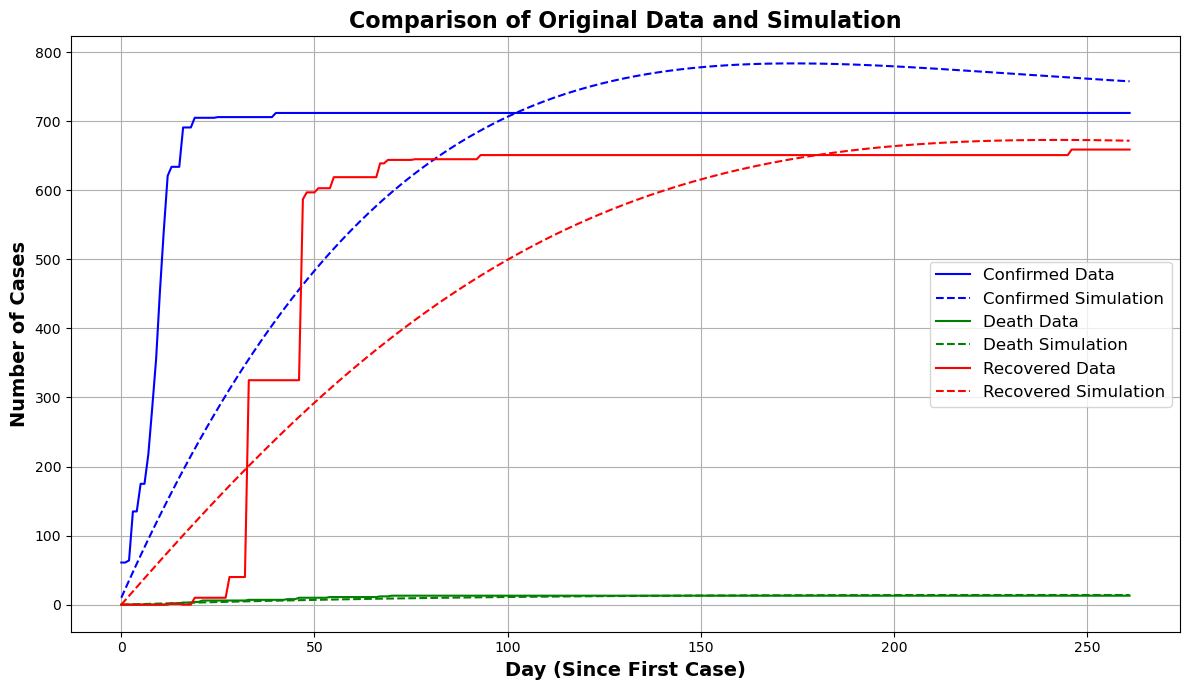

In [35]:
plot_org_sim(U_comp,x_sim,['Confirmed','Death','Recovered'])

In [36]:
norway_data 

,LOCATION,TIME,ELAPSED_TIME_SINCE_OUTBREAK,CONFIRMED,DEATHS,RECOVERED,Day
30058,Norway,2020-02-26 23:59:00,0,1,0,0,1
30059,Norway,2020-02-27 23:59:00,1,1,0,0,2
30060,Norway,2020-02-28 23:59:00,2,6,0,0,3
30061,Norway,2020-02-29 23:59:00,3,15,0,0,4
30062,Norway,2020-03-01 23:59:00,4,19,0,0,5
...,...,...,...,...,...,...,...
30296,Norway,2020-10-21 23:59:00,238,16964,279,11863,239
30297,Norway,2020-10-22 23:59:00,239,17234,279,11863,240
30298,Norway,2020-10-23 23:59:00,240,17532,279,11863,241
30299,Norway,2020-10-24 23:59:00,241,17749,279,11863,242


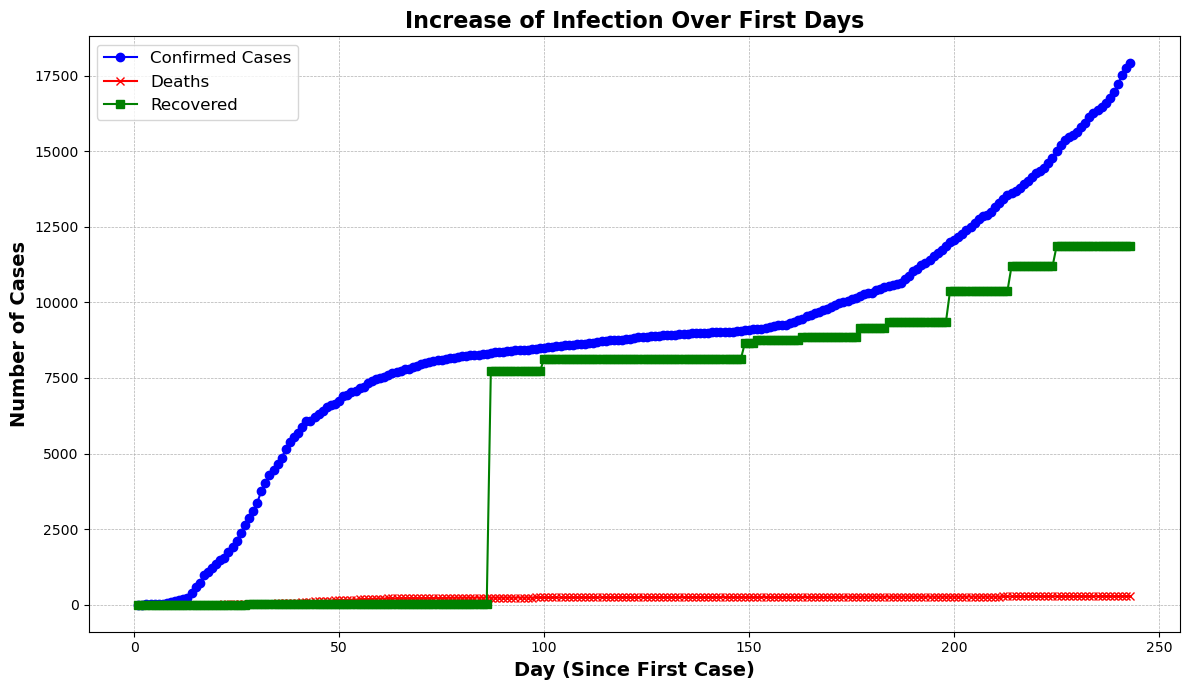

In [37]:
plot_func(norway_data)

In [38]:
b=[  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208,
       209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,
       222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
       235, 236, 237, 238, 239, 240, 241, 242, 243,244, 245, 246, 247, 248, 249, 250, 251, 252,253,254,255,256,257,258,259,260,261,262]

In [39]:
U_comp.shape

(262, 3)

c:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


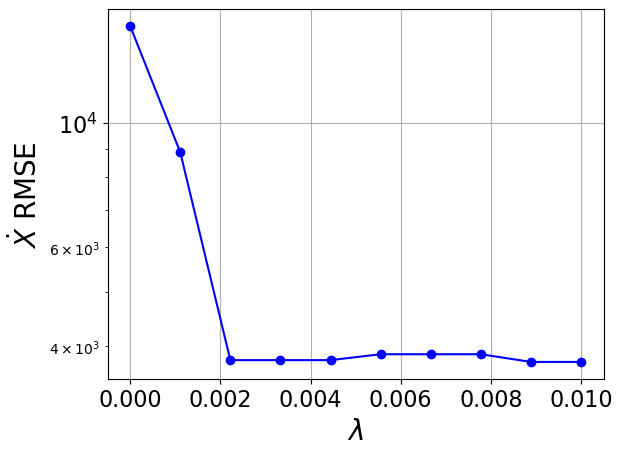

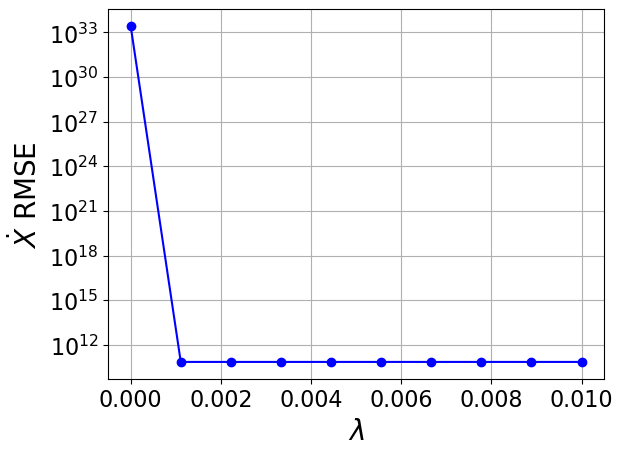

In [40]:
threshold_scan = np.linspace(0.0, 0.010, 10)
coefs = []
for i, threshold in enumerate(threshold_scan):
    sparse_regression_optimizer = ps.STLSQ(threshold=threshold)
    library=ps.PolynomialLibrary(degree=2)
    model_test = ps.SINDy(feature_names=feature_names, feature_library=library, optimizer=sparse_regression_optimizer)
    model_test.fit(U_comp_test_N, t=1, quiet=True)
    coefs.append(model_test.coefficients())
    
plot_pareto(coefs, sparse_regression_optimizer, model_test, threshold_scan, U_comp, b)

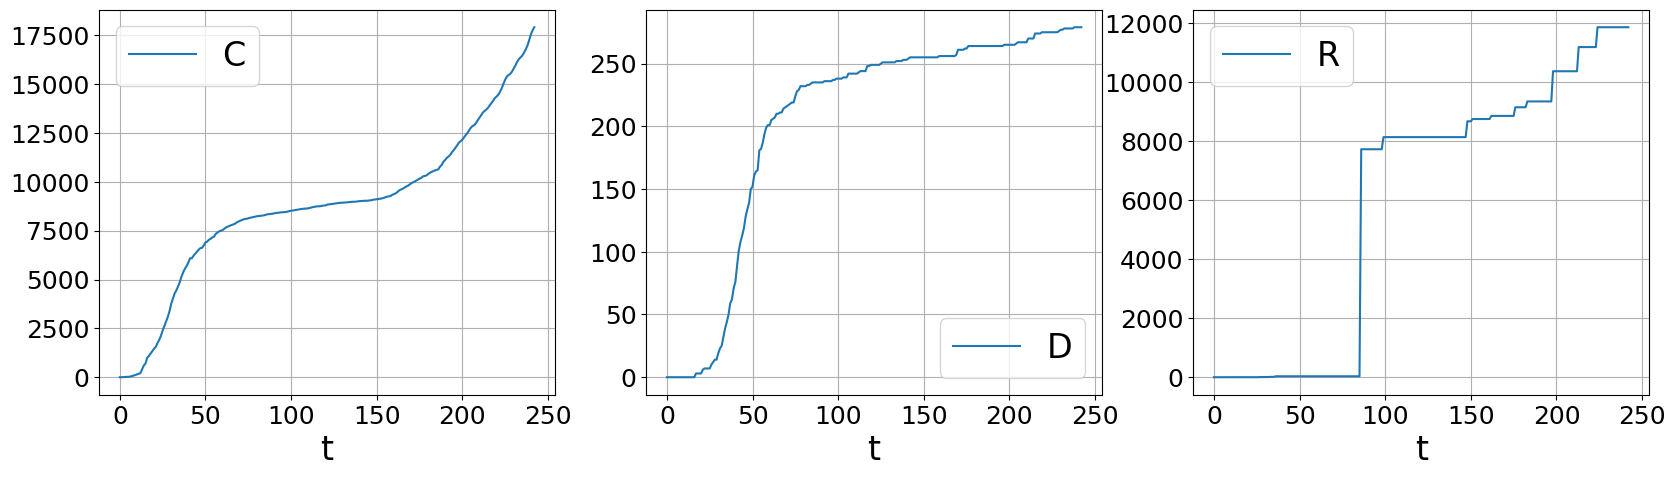

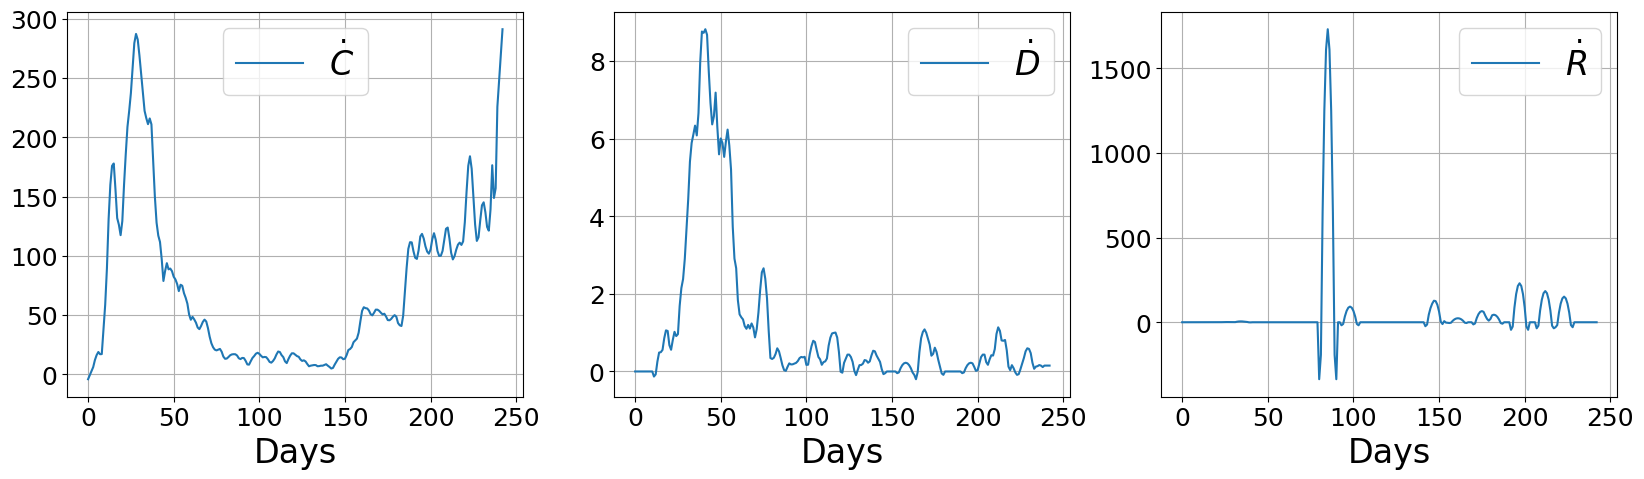

In [41]:
covid_dt=1
plot_data_and_derivative(U_comp_test_N,covid_dt, ps.SmoothedFiniteDifference(smoother_kws={'window_length': 10, 'polyorder': 2})._differentiate)

(C)' = 139.900 1 + 0.018 C + -1.116 D + 0.001 R
(D)' = 3.062 1 + -0.010 D
(R)' = -11.067 1 + -0.001 C + 0.574 D + -0.008 R


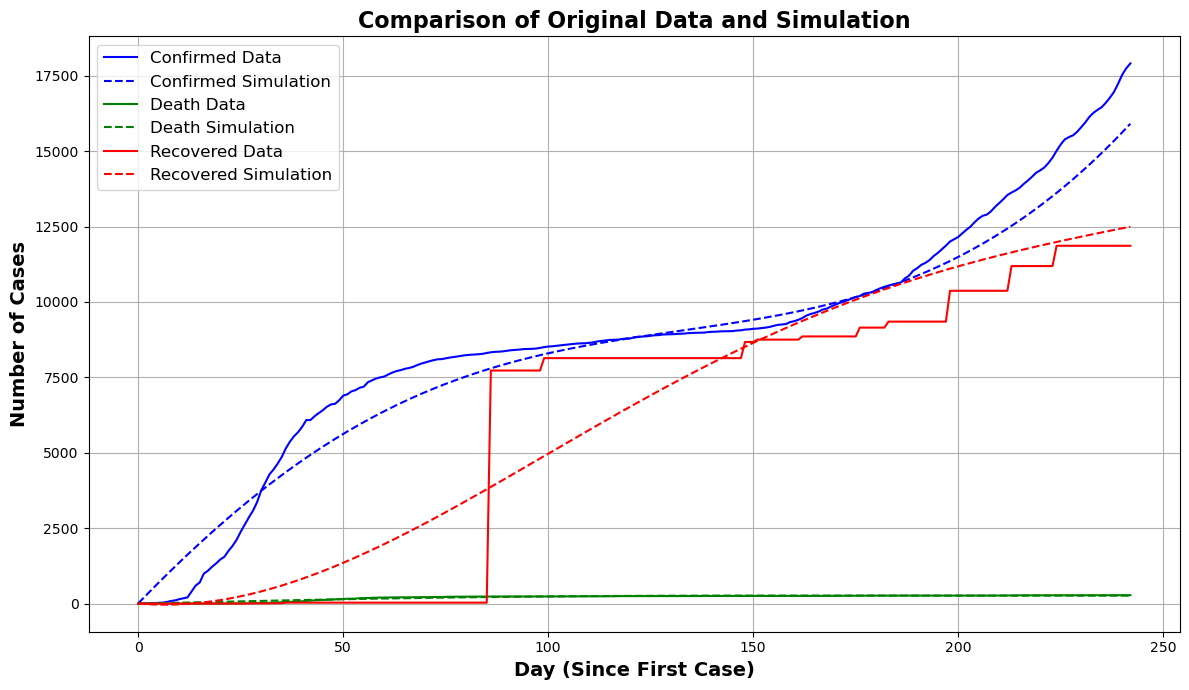

Accuracy: 0.9779733719334015


In [42]:
feature_names= ['C','D','R']
opt=ps.STLSQ(threshold=0.0001)#degree of sparsity  
library=ps.PolynomialLibrary(degree=1)
dm=ps.SmoothedFiniteDifference(smoother_kws={'window_length': 50, 'polyorder': 1})._differentiate
model_covid = ps.SINDy(feature_names=feature_names, feature_library=library,optimizer=opt,differentiation_method=dm)
model_covid.fit(U_comp_test_N, t=1)
model_covid.print()

u0_comp_N=np.array([10,0,0])
x_sim_N=model_covid.simulate(u0_comp_N,t=T_test_N)
plot_org_sim(U_comp_test_N,x_sim_N,['Confirmed','Death','Recovered'])
print("Accuracy: " +str(CalcAccuracy(U_comp_test_N,x_sim_N)))

In [43]:
x_sim_N

array([[ 1.00000000e+01,  1.34897091e-16, -4.87494354e-16],
       [ 1.49630705e+02,  3.06589226e+00, -1.01841485e+01],
       [ 2.88348648e+02,  6.13537295e+00, -1.86004119e+01],
       [ 4.26135589e+02,  9.20770715e+00, -2.52614090e+01],
       [ 5.62973763e+02,  1.22821667e+01, -3.01800607e+01],
       [ 6.98845879e+02,  1.53580301e+01, -3.33695840e+01],
       [ 8.33735126e+02,  1.84345832e+01, -3.48434862e+01],
       [ 9.67625167e+02,  2.15111187e+01, -3.46155579e+01],
       [ 1.10050014e+03,  2.45869365e+01, -3.26998674e+01],
       [ 1.23234468e+03,  2.76613440e+01, -2.91107540e+01],
       [ 1.36314386e+03,  3.07336558e+01, -2.38628222e+01],
       [ 1.49288327e+03,  3.38031942e+01, -1.69709349e+01],
       [ 1.62154896e+03,  3.68692892e+01, -8.45020759e+00],
       [ 1.74912745e+03,  3.99312785e+01,  1.68399825e+00],
       [ 1.87560576e+03,  4.29885076e+01,  1.34160813e+01],
       [ 2.00097136e+03,  4.60403299e+01,  2.67302069e+01],
       [ 2.12521221e+03,  4.90861070e+01

(C)' = 155.390 1 + -0.382 D
(D)' = 3.839 1 + -0.012 D
(R)' = 5.171 1 + 0.224 D


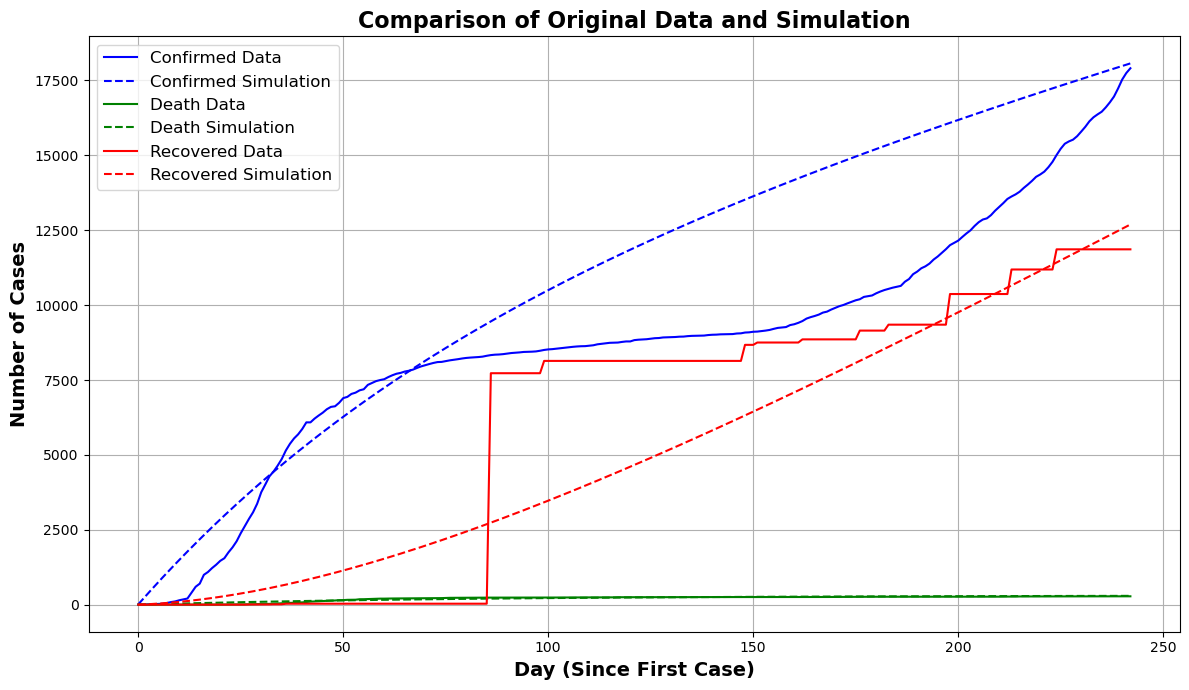

Accuracy: 0.9129651249425558


In [44]:
feature_names= ['C','D','R']
opt=ps.STLSQ(threshold=0.01)#degree of sparsity  
library=ps.PolynomialLibrary(degree=2)
dm=ps.SmoothedFiniteDifference(smoother_kws={'window_length': 50, 'polyorder': 1})._differentiate
model_covid = ps.SINDy(feature_names=feature_names, feature_library=library,optimizer=opt,differentiation_method=dm)
model_covid.fit(U_comp_test_N, t=1)
model_covid.print()

u0_comp_N=np.array([10,0,0])
x_sim_N=model_covid.simulate(u0_comp_N,t=T_test_N)
plot_org_sim(U_comp_test_N,x_sim_N,['Confirmed','Death','Recovered'])
print("Accuracy: " +str(CalcAccuracy(U_comp_test_N,x_sim_N)))

In [45]:
def CalcAccuracy(Actual_Y, Predicted_y):
    
    actual_values=Actual_Y
    predicted_values=np.array(Predicted_y)
    error= abs(actual_values-Predicted_y)
    mse=np.mean(np.square(error))
    rel_err=mse/np.mean(np.square(actual_values))
    accuracy=1-rel_err
    return(accuracy)